# Analysis of the LacI titration data and comparison with theory

This exercise was generated from a Jupyter notebook. You can download the notebook [here](laci_titration_in_class.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

plt.rcParams['image.cmap'] = 'Greys_r'

import skimage.io
import skimage.measure
import skimage.filters

import glob

import pboc_utilities as pboc

# Step 1: Phase image -> Labeled mask

### 1.1 Background subtraction

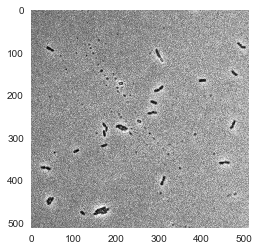

In [2]:
im = skimage.io.imread('data/lacI_titration/O2_R124_phase_pos_02.tif')

plt.imshow(im)
plt.grid('off')

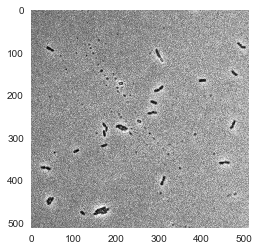

In [3]:
# Normalize the image
im_float = (im - np.min(im))/(np.max(im) - np.min(im))

plt.imshow(im_float)
plt.grid('off')

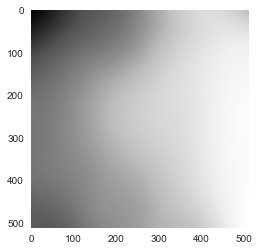

In [4]:
# Gaussian radius in pixels
gauss_radius = 50

# Find the background by applying a Gaussian blur
im_bg = skimage.filters.gaussian(im_float, sigma = gauss_radius)

# Show the background
plt.imshow(im_bg)
plt.grid('off')

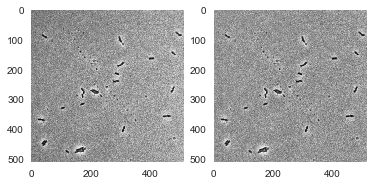

In [5]:
# Subtract the background from the image
im_deblur = im_float - im_bg

# Show the original and deblurred images together
fig, ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[0].grid('off')

ax[1].imshow(im_deblur)
ax[1].grid('off')

### 1.2 Thresholding

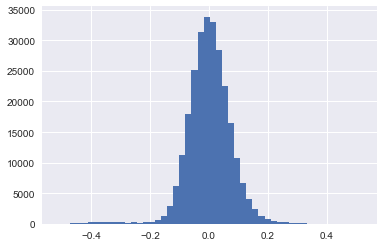

In [6]:
# Make a histogram of pixel values of the deblurred image
_ = plt.hist(im_deblur.flatten(), bins = 50)

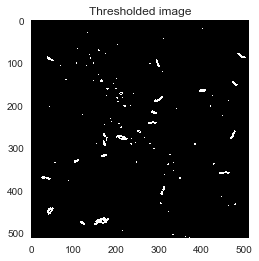

In [7]:
# Threshold
threshold = -0.2

# Threshold the image
im_thresh = im_deblur < threshold

# Show the thresholded image
plt.imshow(im_thresh)
plt.title('Thresholded image')
plt.grid('off')

### 1.3 Remove small objects and label the cells

In [8]:
# Label the objects in the thresholded image
im_label, n_objects = skimage.measure.label(im_thresh, return_num = True)

print(str(n_objects) + ' found in the thresholded image')

179 found in the thresholded image


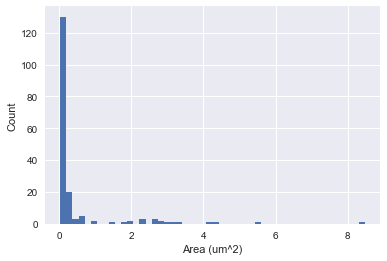

In [9]:
# Extract the morphological properties of the objects found
props = skimage.measure.regionprops(im_label)

# List to store area values in um^2
areas = []

# Distance calibration in um/pixel
pixel_len = 0.16

# A [px^2] * c^2 [um^2 / px^2] = A c^2 [um^2]
for prop in props:
    areas.append(prop.area * pixel_len**2)
    
# Make a histogram of object areas
_ = plt.hist(areas, bins = 50)
plt.xlabel('Area (um^2)')
plt.ylabel('Count')

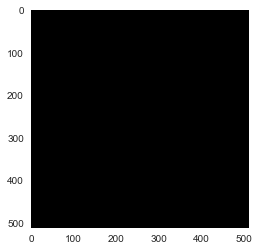

In [10]:
# Limits on the area in um^2
area_low = 1
area_high = 5

# Create a black image
im_mask = np.zeros_like(im_thresh)

plt.imshow(im_mask)
plt.grid('off')

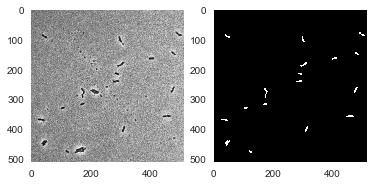

In [11]:
for prop in props:
    area = prop.area * pixel_len**2
    if (area > area_low) and (area < area_high):
        im_mask = im_mask + (im_label == prop.label)
        
#         plt.figure()
#         plt.imshow(im_mask)
#         plt.grid('off')

# Show the masked image along with the original
fig, ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[0].grid('off')

ax[1].imshow(im_mask)
ax[1].grid('off')

In [12]:
# Label the mask
im_mask_label, n_objects_mask = skimage.measure.label(im_mask, return_num=True)

print(str(n_objects_mask) + ' objects remained after the size filtering.')

17 objects remained after the size filtering.


# Step 2: Labeled mask + YFP image -> List of intensity values

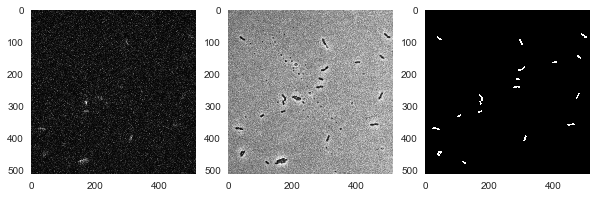

In [13]:
# Read the corresponding YFP image
im_yfp = skimage.io.imread('data/lacI_titration/O2_R124_yfp_pos_02.tif')

# Show the YFP channel image next to the original and the mask
fig, ax = plt.subplots(1,3, figsize = [10, 5])
ax[0].imshow(im_yfp)
ax[0].grid('off')

ax[1].imshow(im)
ax[1].grid('off')

ax[2].imshow(im_mask)
ax[2].grid('off')

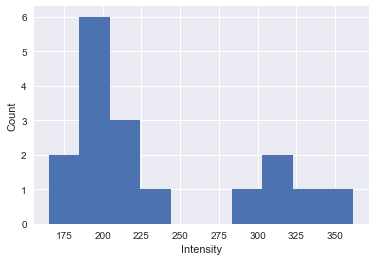

In [23]:
# Extract the features of objects in the YFP channel
im_mask_label = pboc.create_mask(im)
props_yfp = skimage.measure.regionprops(im_mask_label, intensity_image=im_yfp)

# List to store intensity values
intensities = []

for prop in props_yfp:
    intensities.append(prop.mean_intensity)
    
_ = plt.hist(intensities)
plt.xlabel('Intensity')
plt.ylabel('Count')

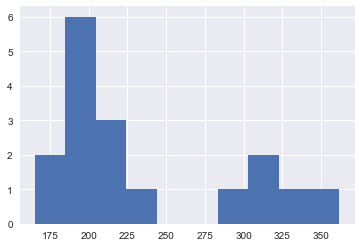

In [25]:
# Intensity values outputted by the function
intensities_fn = pboc.find_intensities(im_yfp, im_mask_label)

_ = plt.hist(intensities_fn)

# Step 3: Extract intensity information from all cells of a given strain

In [26]:
# Specify the strain
operator = 'O2'
repressor = 'R124'

# Extract all intensity values
intensities_all = pboc.find_intensities_all(operator, repressor)

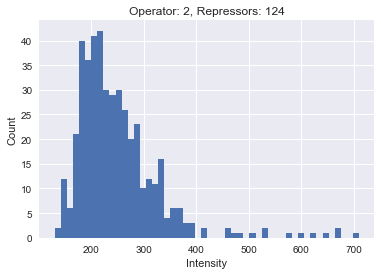

In [32]:
# Histogram of intensity values of cells from O2_R124 strain
_ = plt.hist(intensities_all, bins = 50)
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Operator: 2, Repressors: 124');

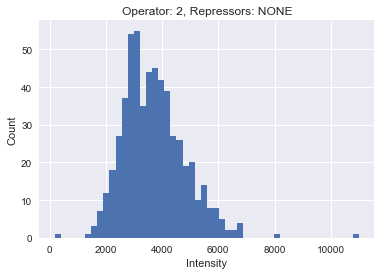

In [35]:
# Intensities in constitutive expression strain
intensities_all_delta = pboc.find_intensities_all(operator, repressor = 'delta')

_ = plt.hist(intensities_all_delta, bins = 50)
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Operator: 2, Repressors: NONE');

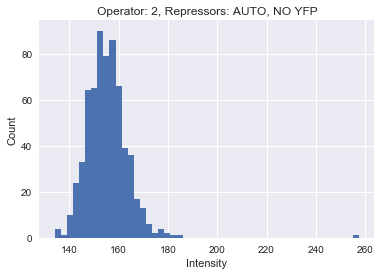

In [36]:
# Intensities in autofluorescence strain
intensities_all_auto = pboc.find_intensities_all(operator, repressor = 'auto')

_ = plt.hist(intensities_all_auto, bins = 50)
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Operator: 2, Repressors: AUTO, NO YFP');

# Step 4: Calculate the fold-change for a single strain

In [38]:
repressor

'R124'

In [39]:
operator

'O2'

In [40]:
# Find the mean intensities in three different strains
# - Strain with regulated expression
# - Strain with consqitutive expression
# - Strain with autofluorescence

intensities_all_repressor = pboc.find_intensities_all(operator, repressor)
intensity_mean_repressor = np.mean(intensities_all_repressor)

intensities_all_delta = pboc.find_intensities_all(operator, 'delta')
intensity_mean_delta = np.mean(intensities_all_delta)

intensities_all_auto = pboc.find_intensities_all(operator, 'auto')
intensity_mean_auto = np.mean(intensities_all_auto)

In [41]:
print('Mean intensity in R-strain: ' + str(intensity_mean_repressor))
print('Mean intensity in delta-strain: ' + str(intensity_mean_delta))
print('Mean intensity in auto-strain: ' + str(intensity_mean_auto))

Mean intensity in R-strain: 249.692162745
Mean intensity in delta-strain: 3703.40478041
Mean intensity in auto-strain: 155.232048147


In [42]:
fold_change = (intensity_mean_repressor - intensity_mean_auto) / (intensity_mean_delta - intensity_mean_auto)
print('Fold-change for O2:R124 strain: ' + str(fold_change))

Fold-change for O2:R124 strain: 0.0266221860449


In [43]:
def find_fold_change (operator, repressor):
    
    intensities_all_repressor = pboc.find_intensities_all(operator, repressor)
    intensity_mean_repressor = np.mean(intensities_all_repressor)

    intensities_all_delta = pboc.find_intensities_all(operator, 'delta')
    intensity_mean_delta = np.mean(intensities_all_delta)

    intensities_all_auto = pboc.find_intensities_all(operator, 'auto')
    intensity_mean_auto = np.mean(intensities_all_auto)
    
    return (intensity_mean_repressor - intensity_mean_auto) / (intensity_mean_delta - intensity_mean_auto)

In [44]:
# Check that it's working
find_fold_change('O2','R124')

0.026622186044921586

# Step 5: Find fold-change values for all the strains

In [48]:
# List of strain information
operators = ['O1', 'O2', 'O3']
repressors = ['R22', 'R60', 'R124', 'R260', 'R1220', 'R1740']


# Number of different operators
n_operators = len(operators)
print('Number of different operators: ' + str(n_operators))

# Number of different repressor counts
n_repressors = len(repressors)
print('Number of different repressor counts: ' + str(n_repressors))

# Array to store fold-change values
fold_change_values = np.zeros([n_operators, n_repressors])

for i in range(n_operators):
    for j in range(n_repressors):
        fold_change_values[i,j] = find_fold_change(operators[i], repressors[j])

Number of different operators: 3
Number of different repressor counts: 6


# Step 6: Theory predictions

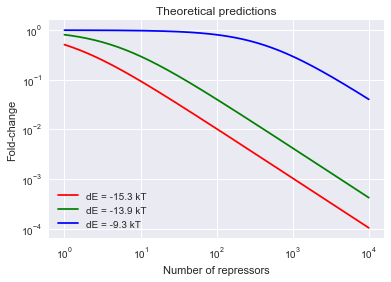

In [67]:
# Binding energy values in kT units
dE = [-15.3, -13.9, -9.3]

# Colors
colors = ['r', 'g', 'b']

# Number of non-specific sites, i.e. length of the E. coli DNA
nNS = 4.6E6 # 4,600,000

# Range of repressor copy numbers for plotting the curves
R_range = np.logspace(0, 4, 200)

for i in range(n_operators):
    
    # Theoretical estimates of the fold-change
    fc_theory = 1 / (1 + R_range/nNS * np.exp(-dE[i]))
    
    # Plot the dependence of the fold-change on the repressor copy number
    plt.loglog(R_range, fc_theory, color = colors[i], label = 'dE = ' + str(dE[i]) + ' kT')
    
plt.xlabel('Number of repressors')
plt.ylabel('Fold-change')
plt.title('Theoretical predictions')
plt.legend()
plt.show()

# Step 7: Compare theory predictions and experimental results

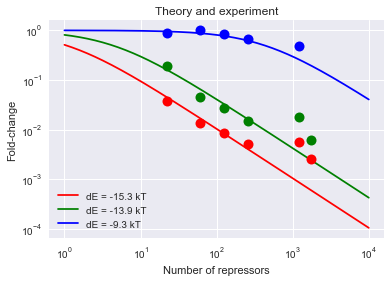

In [74]:
for i in range(n_operators):
    
    # Theoretical estimates of the fold-change
    fc_theory = 1 / (1 + R_range/nNS * np.exp(-dE[i]))
    
    # Plot the dependence of the fold-change on the repressor copy number
    plt.loglog(R_range, fc_theory, color = colors[i], label = 'dE = ' + str(dE[i]) + ' kT')
    
repressor_counts = [22, 60, 124, 260, 1220, 1740]

for i in range(n_operators):
    plt.loglog(repressor_counts, fold_change_values[i,:], '.', markersize = 20, color = colors[i])

    
plt.xlabel('Number of repressors')
plt.ylabel('Fold-change')
plt.title('Theory and experiment')
plt.legend()
plt.show()